In [1]:
try:
    import nltk
except ModuleNotFoundError:
    !pip install nltk

In [2]:
## This code downloads the required packages.
## You can run `nltk.download('all')` to download everything.

nltk_packages = [
    ("reuters", "corpora/reuters.zip")
]

for pid, fid in nltk_packages:
    try:
        nltk.data.find(fid)
    except LookupError:
        nltk.download(pid)

## Setting up corpus

In [3]:
from nltk.corpus import reuters

## Setting up train/test data

In [4]:
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('test/')])

In [5]:
all_categories = sorted(list(set(reuters.categories())))

# Add your code here

The following cell defines a function **tokenize** that performs following actions:
- Receive a document as an argument to the function
- Tokenize the document using `nltk.word_tokenize()`
- Use `PorterStemmer` provided by the `nltk` to remove morphological affixes from each token
- Append stemmed token to an already defined list `stems`
- Return the list `stems`

In [6]:
from nltk.stem.porter import PorterStemmer
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

To begin, I first used TF-IDF for feature selection on both train as well as test data using `TfidfVectorizer`.

But first, What `TfidfVectorizer` actually does?
- `TfidfVectorizer` converts a collection of raw documents to a matrix of **TF-IDF** features.

**TF-IDF**?
- TFIDF (abbreviation of the term *frequency–inverse document frequency*) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. [tf–idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

**Why `TfidfVectorizer`**?
- `TfidfVectorizer` scale down the impact of tokens that occur very frequently (e.g., “a”, “the”, and “of”) in a given corpus. [Feature Extraction and Transformation](https://spark.apache.org/docs/latest/mllib-feature-extraction.html#tf-idf)

I gave following two arguments to `TfidfVectorizer`:
- tokenizer: `tokenize` function
- stop_words

Then I used `fit_transform` and `transform` on the train and test documents repectively.

**Why `fit_transform` for training data while `transform` for test data**?

To avoid data leakage during cross-validation, imputer computes the statistic on the train data during the `fit`, **stores it** and uses the same on the test data, during the `transform`. This also prevents the test data from appearing in `fit` operation.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words = 'english')

vectorised_train_documents = vectorizer.fit_transform(train_documents)
vectorised_test_documents = vectorizer.transform(test_documents)

For the **efficient implementation** of machine learning algorithms, many machine learning algorithms **requires all input variables and output variables to be numeric**. This means that categorical data must be converted to a numerical form.

For this purpose, I used `MultiLabelBinarizer` from `sklearn.preprocessing`.

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_categories)
test_labels = mlb.transform(test_categories)

Now, To **train** the classifier, I used `LinearSVC` in combination with the `OneVsRestClassifier` function in the scikit-learn package.

The strategy of `OneVsRestClassifier` is of **fitting one classifier per label** and the `OneVsRestClassifier` can efficiently do this task and also outputs are easy to interpret. Since each label is represented by **one and only one classifier**, it is possible to gain knowledge about the label by inspecting its corresponding classifier. [OneVsRestClassifier](http://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest)

The reason I combined `LinearSVC` with `OneVsRestClassifier` is because `LinearSVC` supports **Multi-class**, while we want to perform **Multi-label** classification.

In [9]:
%%capture
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

classifier = OneVsRestClassifier(LinearSVC())
classifier.fit(vectorised_train_documents, train_labels)

After fitting the classifier, I decided to use `cross_val_score` to **measure score** of the classifier by **cross validation** on the training data. But the only problem was, I wanted to **shuffle** data to use with `cross_val_score`, but it does not support shuffle argument.

So, I decided to use `KFold` with `cross_val_score` as `KFold` supports shuffling the data.

I also enabled `random_state`, because `random_state` will guarantee the same output in each run. By setting the `random_state`, it is guaranteed that the pseudorandom number generator will generate the same sequence of random integers each time, which in turn will affect the split.

Why **42**?
- [Why '42' is the preferred number when indicating something random?](https://softwareengineering.stackexchange.com/questions/507/why-42-is-the-preferred-number-when-indicating-something-random)

In [10]:
%%capture
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, random_state = 42, shuffle = True)
scores = cross_val_score(classifier, vectorised_train_documents, train_labels, cv = kf)

In [11]:
print('Cross-validation scores:', scores)
print('Cross-validation accuracy: {:.4f} (+/- {:.4f})'.format(scores.mean(), scores.std() * 2))

Cross-validation scores: [0.83655084 0.86743887 0.8043758  0.83011583 0.83655084 0.81724582
 0.82754183 0.8030888  0.80694981 0.82731959]
Cross-validation accuracy: 0.8257 (+/- 0.0368)


In the end, I used different methods (`accuracy_score`, `precision_score`, `recall_score`, `f1_score` and `confusion_matrix`) provided by scikit-learn **to evaluate** the classifier. (both *Macro-* and *Micro-averages*)

In [12]:
%%capture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

predictions = classifier.predict(vectorised_test_documents)

accuracy = accuracy_score(test_labels, predictions)

macro_precision = precision_score(test_labels, predictions, average='macro')
macro_recall = recall_score(test_labels, predictions, average='macro')
macro_f1 = f1_score(test_labels, predictions, average='macro')

micro_precision = precision_score(test_labels, predictions, average='micro')
micro_recall = recall_score(test_labels, predictions, average='micro')
micro_f1 = f1_score(test_labels, predictions, average='micro')

cm = confusion_matrix(test_labels.argmax(axis = 1), predictions.argmax(axis = 1))

In [13]:
print("Accuracy: {:.4f}\nPrecision:\n- Macro: {:.4f}\n- Micro: {:.4f}\nRecall:\n- Macro: {:.4f}\n- Micro: {:.4f}\nF1-measure:\n- Macro: {:.4f}\n- Micro: {:.4f}".format(accuracy, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))

Accuracy: 0.8099
Precision:
- Macro: 0.6076
- Micro: 0.9471
Recall:
- Macro: 0.3708
- Micro: 0.7981
F1-measure:
- Macro: 0.4410
- Micro: 0.8662


In below cell, I used `matplotlib.pyplot` to **plot the confusion matrix** (of first *few results only* to keep the readings readable) using `heatmap` of `seaborn`.

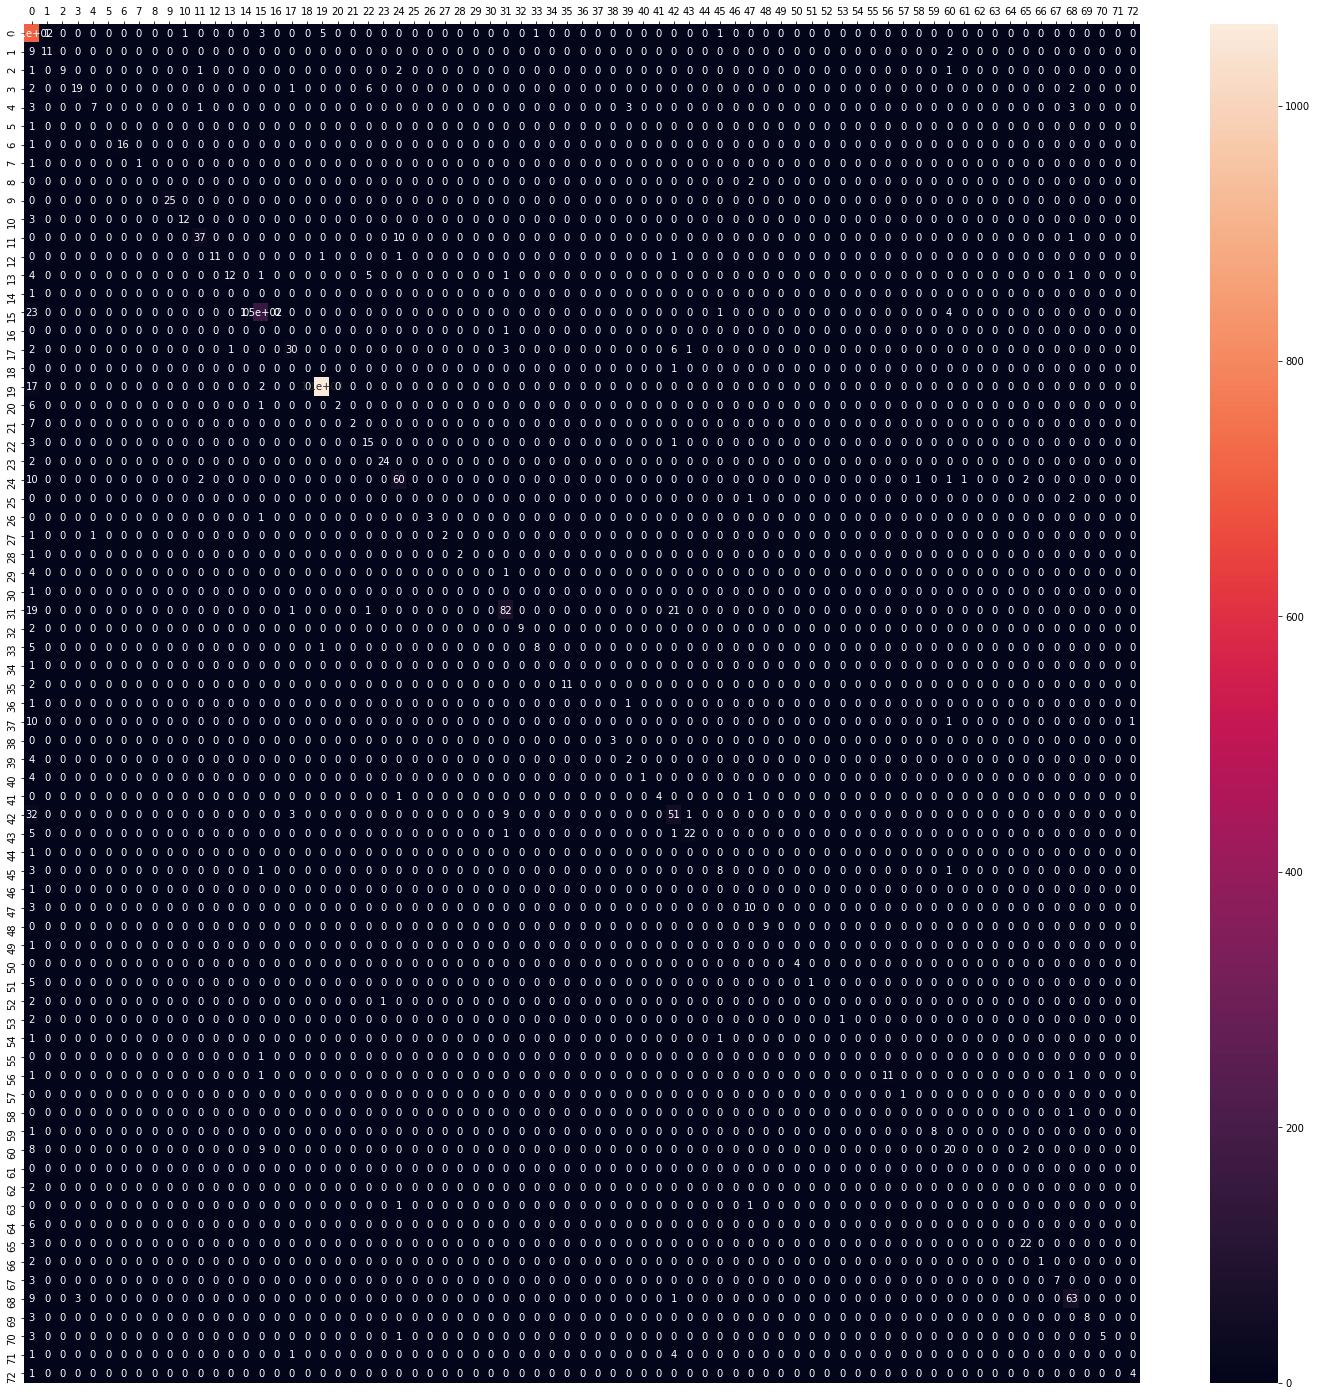

In [16]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

cm_plt = pd.DataFrame(cm[:73])

plt.figure(figsize = (25, 25))
ax = plt.axes()

sb.heatmap(cm_plt, annot=True)

ax.xaxis.set_ticks_position('top')

plt.show()

### Pipeline

Now, I took the data from [Coconut - Wikipedia](https://en.wikipedia.org/wiki/Coconut) to check if the classifier is able to **correctly** predict the label(s) or not.

And here is the output:

In [15]:
example_text = '''The coconut tree (Cocos nucifera) is a member of the family Arecaceae (palm family) and the only species of the genus Cocos.
The term coconut can refer to the whole coconut palm or the seed, or the fruit, which, botanically, is a drupe, not a nut.
The spelling cocoanut is an archaic form of the word.
The term is derived from the 16th-century Portuguese and Spanish word coco meaning "head" or "skull", from the three indentations on the coconut shell that resemble facial features.
Coconuts are known for their versatility ranging from food to cosmetics.
They form a regular part of the diets of many people in the tropics and subtropics.
Coconuts are distinct from other fruits for their endosperm containing a large quantity of water (also called "milk"), and when immature, may be harvested for the potable coconut water.
When mature, they can be used as seed nuts or processed for oil, charcoal from the hard shell, and coir from the fibrous husk.
When dried, the coconut flesh is called copra.
The oil and milk derived from it are commonly used in cooking and frying, as well as in soaps and cosmetics.
The husks and leaves can be used as material to make a variety of products for furnishing and decorating.
The coconut also has cultural and religious significance in certain societies, particularly in India, where it is used in Hindu rituals.'''

example_preds = classifier.predict(vectorizer.transform([example_text]))
example_labels = mlb.inverse_transform(example_preds)
print("Example labels: {}".format(example_labels))

Example labels: [('coconut', 'oilseed')]
